# Drive Mount #

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ** Utils.py Import ** #

In [35]:
""" Utils for importing images and data """

## library imports ##
import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


## func to import test and val images
def import_others(img_dir, img_num=int):
    """ Import images from the specified directory """
    start = time.time()
    processed_images = []
    img_paths = []

    def process_image_batches(img_paths, processed_images, img_num):
        """ Import images from the specified directory """

        # read in image, resize, grayscale, and normalize
        for i in range(0, img_num):
            img_path = cv2.imread(img_paths[i])
            img = cv2.resize(img_path, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis = 2)
            img = img / 255.0
            processed_images.append(img)
            completed_percentage = (i / img_num) * 100
            if completed_percentage in [25, 50, 75, 100]:
                print(f"Images processed: {i} ({round(completed_percentage)}%)")

    # collect image paths
    for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.endswith(".JPEG"):
                     img_paths.append(os.path.join(root, file))

    # shuffle images to get random images from random folders and process while generating labels
    random.shuffle(img_paths)
    process_image_batches(img_paths, processed_images, img_num)

    # return run stats and data
    end = time.time()
    print(f"Function processed {img_dir} in {round(end - start)} seconds.\n")
    return processed_images


## func to view training images with their assigned labels
def view_train_images(x, y, n = 5):
    """ view train data """
    for img in range(0, 5):
        plt.imshow(x[img], cmap="gray")
        plt.show()
        print(y[img])


def plot_training_results(history):
     """ Plot Accuracy Results """
     plt.figure(figsize=(12, 4))
     plt.subplot(1, 2, 1)
     plt.plot(history.history['accuracy'])
     plt.plot(history.history['val_accuracy'])
     plt.title('Model Accuracy')
     plt.xlabel('Epoch')
     plt.ylabel('Accuracy')
     plt.legend(['Train', 'Val'], loc='best')
     plt.show()

     """ Plot Loss Results """
     plt.subplot(1, 2, 2)
     plt.plot(history.history['loss'])
     plt.plot(history.history['val_loss'])
     plt.title('Model Loss')
     plt.xlabel('Epoch')
     plt.ylabel('Loss')
     plt.legend(['Train', 'Val'], loc='best')
     plt.show()


def fast_import2(img_dir, img_num=int):
    """ Import and preprocess images concurrently from the specified directory """
    start = time.time()

    # Helper function to process individual images
    def process_image(img_path):
        """ Read and preprocess a single image, returning the processed image and its label """
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis=2)
        img = img / 255.0
        label = img_path.split(os.path.sep)[-2]  # label is the parent folder of the image
        return img, label

    # Collect image paths
    img_paths = [os.path.join(root, file)
                 for root, dirs, files in os.walk(img_dir)
                 for file in files if file.endswith(".JPEG")]

    # Shuffle images to get random images from random folders
    random.shuffle(img_paths)
    img_num = min(img_num, len(img_paths))
    img_paths = img_paths[:img_num]

    # Use ThreadPoolExecutor to process images concurrently and yield results
    with ThreadPoolExecutor(max_workers=8) as executor:  # You can adjust the number of threads here
        results = executor.map(process_image, img_paths)
        for img, label in results:
            yield img, label


    # Output stats (This part might need adjustment if you want to print stats after yielding all images)
    end = time.time()
    print(f"Function finished processing images from {img_dir} in {round(end - start)} seconds.\n")


# func to get data for CV project
def get_images(train_dir, val_dir, train_num = 0):
    """ Get data for CV project """
    X_train, Y_train = fast_import2(train_dir, train_num)
    X_val, Y_val = fast_import2(val_dir, int(.15 * train_num))
    return X_train, Y_train, X_val, Y_val

https://hub.docker.com/r/tensorflow/tensorflow

In [17]:
# Import libraries
import os
import cv2
import time
import random
import gc as G
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import backend as K, mixed_precision
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau as RLOP
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


In [18]:
# # set up for GPU usage
K.clear_session()
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")


2.18.0
Num GPUs Available:  1
Using device: /GPU:0


In [19]:
# limit usage of GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents TensorFlow from allocating all memory at once
            print(f"Enabled memory growth for: {gpu}")

        # Set GPU device
        device = "/GPU:0"
    except RuntimeError as e:
        print(e)
else:
    device = "/CPU:0"
    print("No GPU detected, using CPU.")

print(f"Using device: {device}")

# set gpu to use max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4000)]  # Set in MB (e.g., 10GB)
            )
        print("Set TensorFlow to use max GPU memory.")
    except RuntimeError as e:
        print(e)


ValueError: Cannot set memory growth on device when virtual devices configured

# 1) Data Import #

In [11]:
# paths for data
train_dir = "/content/drive/MyDrive/Colab Notebooks/data/small_train"
# val_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val"
# test_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test"


In [36]:
# import images
train_generator = fast_import2(train_dir, 5000)
# test_images = import_others(test_dir, 750)
# val_images = import_others(val_dir, 750)

In [37]:
with tf.device(device):
  # prepare training data
  # tf.compat.v1.disable_eager_execution()
  X_train = []
  Y_train = []
  for img, label in train_generator:
      X_train.append(img)
      Y_train.append(label)

  X_train = np.array(X_train)
  X_train = np.repeat(X_train, 3, -1)

  Y_train = [str(s) for s in Y_train]
  label_encoder = LabelEncoder()
  Y_train = label_encoder.fit_transform(Y_train)
  Y_hot = to_categorical(Y_train)

Function finished processing images from /content/drive/MyDrive/Colab Notebooks/data/small_train in 133 seconds.



# 4) Model Definition #

### c) Test Base Model ###

In [40]:
def build_model(lr=0.05):
  CNN2 = keras.Sequential([
                    # first convolutional layer
                    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # second convolutional layer with 64 neurons and w/out shape
                    Conv2D(64, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # third convolutional layer with 64 neurons and w/out shape
                    Conv2D(64, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    # # Flatten out the layers
                    # Flatten(),
                    # Dense layer with 64 neurons and relu activation
                    GlobalAveragePooling2D(),
                    BatchNormalization(),
                    # Dropout layer to prevent overfitting by dropping 50% of neurons
                    Dropout(0.4),
                    # Output layer with 1000 classes and softmax activation
                    Dense(len(Y_hot[0]), activation='softmax')
            ])
  CNN2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(), Recall()])
  return CNN2

def train_model(model, batch=0, epx=0):
  hist = model.fit(
          X_train, Y_hot,
          batch_size=batch,
          epochs=epx,
          validation_split=0.2
        )
  return hist

def test_all(lr, model, batch, epx):
  return plot_training_results(train_model(build_model(lr), batch=batch, epx=epx))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.1141 - loss: 3.0850 - precision_1: 0.1046 - recall_1: 0.0063 - val_accuracy: 0.0740 - val_loss: 3.0132 - val_precision_1: 0.1972 - val_recall_1: 0.0140
Epoch 2/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1558 - loss: 2.6216 - precision_1: 0.1683 - recall_1: 0.0015 - val_accuracy: 0.0500 - val_loss: 3.6089 - val_precision_1: 0.0560 - val_recall_1: 0.0470
Epoch 3/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1614 - loss: 2.6177 - precision_1: 0.3260 - recall_1: 0.0031 - val_accuracy: 0.0660 - val_loss: 3.0838 - val_precision_1: 0.1786 - val_recall_1: 0.0100
Epoch 4/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1825 - loss: 2.5684 - precision_1: 0.5914 - recall_1: 0.0060 - val_accuracy: 0.0750 - val_loss: 4.6547 - val_precision_1: 0.1489 - val_recall_1: 0.0210
Epoch 5/250
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2247 - loss: 2.4714 - precision_1: 0.4342 - recall_

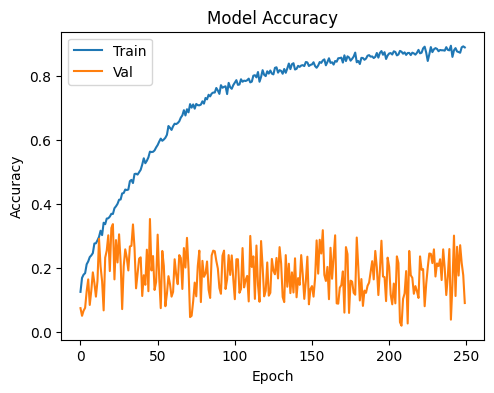

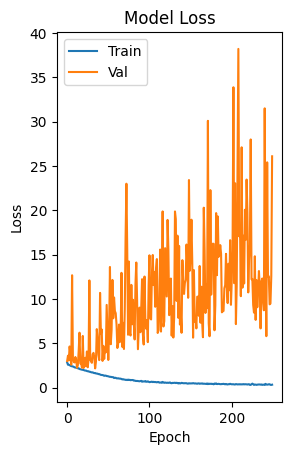

0

In [47]:
test_all(0.02, train_model(build_model()), 32, 250)
K.clear_session()
G.collect()